In [2]:
import nengo
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from simplified_stdp import STDP
from DataLog import DataLog
import tensorflow as tf
import os
from nengo.dists import Choice
from datetime import datetime
from nengo_extras.data import load_mnist
import pickle
plt.rcParams.update({'figure.max_open_warning': 0})

from nengo.utils.matplotlib import rasterplot


In [5]:
#############################
# load the data
#############################

img_rows, img_cols = 28, 28
input_nbr = 100

(image_train, label_train), (image_test, label_test) = (tf.keras.datasets.mnist.load_data())

#select the 0s and 1s as the two classes from MNIST data
image_train_filtered = []
label_train_filtered = []

x = 0
for i in range(0,input_nbr):
  if label_train[i] == x:
        image_train_filtered.append(image_train[i])
        label_train_filtered.append(label_train[i])
        if x == 0:
            x = 1
        else:
            x = 0

image_train_filtered = np.array(image_train_filtered)
label_train_filtered = np.array(label_train_filtered)

In [6]:
#############################
# Helpfull methodes
#############################

def sparsity_measure(vector):  # Gini index
    # Max sparsity = 1 (single 1 in the vector)
    v = np.sort(np.abs(vector))
    n = v.shape[0]
    k = np.arange(n) + 1
    l1norm = np.sum(v)
    summation = np.sum((v / l1norm) * ((n - k + 0.5) / n))
    return 1 - 2 * summation

def HeatMapSave(network,name,probe,samples=1,neuron=1):
    x = int(samples/100)

    if not os.path.exists(name):
        os.makedirs(name)

    plt.matshow(np.reshape(network.data[probe][:,neuron][samples-1],(28,28)))
    plt.title(samples-1)
    plt.savefig(name+"/"+str(neuron)+":"+str(samples-1)+".png")
    plt.cla()

def AllHeatMapSave(network,probe,folder,samples=1,neuron=1):

    if not os.path.exists(folder):
        os.makedirs(folder)
    
    os.makedirs(folder+"/"+str(neuron))
    i = 0
    step = samples / 100
    while i < samples:
        plt.matshow(np.reshape(network.data[probe][:,neuron][i],(28,28))) # , cmap=cm.jet
        plt.title(i)
        plt.savefig(folder+"/"+str(neuron)+"/"+str(neuron)+":"+str(i)+".png")
        plt.cla()
        i = int(i + step)


In [15]:
model = nengo.Network("My network")
#############################
# Model construction
#############################

presentation_time = 0.35 #0.20
#input layer

n_in = 784
n_neurons = 2

# log = DataLog()
with model:

    # input layer 
    picture = nengo.Node(nengo.processes.PresentInput(image_train_filtered, presentation_time))
    true_label = nengo.Node(nengo.processes.PresentInput(label_train_filtered, presentation_time))
    
    input_layer = nengo.Ensemble(
        784,
        1,
        label="input",
        max_rates=nengo.dists.Uniform(255/3, 255/3),
        intercepts=nengo.dists.Choice([0])
        )
    input_conn = nengo.Connection(picture,input_layer.neurons,synapse=None)

    # weights randomly initiated 
    layer1_weights = random.random((n_neurons, 784))
   

    # define first layer
    layer1 = nengo.Ensemble(
         n_neurons,
         1,
         neuron_type=nengo.neurons.AdaptiveLIF(),
         label="layer1",
         max_rates=nengo.dists.Uniform(22,22),
         intercepts=nengo.dists.Choice([0])
         )

   
    w = nengo.Node(CustomRule(), size_in=784, size_out=2)
    nengo.Connection(input_layer.neurons, w, synapse=None)
    nengo.Connection(w, layer1.neurons, synapse=None)
    weights = w.output.history

    # define connection between the two layers
#     conn1 = nengo.Connection(
#         input_layer.neurons,
#         layer1.neurons,
#         transform=layer1_weights,
#         synapse=None,
# #         learning_rule_type = [nengo.BCM(learning_rate=5e-10),nengo.Oja(learning_rate=2e-9)]
#         learning_rule_type=STDP()
#         )

    # create inhibitory layer 
#     layer1_inh = nengo.Ensemble(
#          n_neurons,
#          1,
#          neuron_type=nengo.neurons.LIF(),
#          label="layer1",
#          max_rates=nengo.dists.Uniform(100,100),
#          intercepts=nengo.dists.Choice([0])
#          )
    
#     exc_inh_wegihts = np.eye(n_neurons)
#     inh_exc_wegihts = (np.full((n_neurons, n_neurons), 1) - np.eye(n_neurons)) * -5
    
#     conn_exc_inh = nengo.Connection(layer1.neurons, layer1_inh.neurons, transform=exc_inh_wegihts)
#     conn_inh_exc = nengo.Connection(layer1_inh.neurons, layer1.neurons, transform=inh_exc_wegihts)
    
    
    inhib_wegihts = (np.full((n_neurons, n_neurons), 1) - np.eye(n_neurons)) * -2

    inhib = nengo.Connection(layer1.neurons, layer1.neurons, transform=inhib_wegihts)
        
    #############################

    #############################
    # setup the probes
    #############################

#     connection_layer1_probe = nengo.Probe(conn1,"weights",label="layer1_synapses") 
    
    p_true_label = nengo.Probe(true_label)
    p_layer_1 = nengo.Probe(layer1.neurons)

    
with nengo.Simulator(model) as sim:

#     log.set(sim,"Log.txt",False,False)
    w.output.set_signal(sim.signals[sim.model.sig[layer1.neurons]["voltage"]])
    sim.run((presentation_time) * label_train_filtered.shape[0])

#save the model
# pickle.dump(sim.data[connection_layer1_probe][-1], open( "mnist_params_STDP", "wb" ))
# log.closeLog()

now = str(datetime.now().time())
folder = "My Sim "+now

# for i in range(0,(n_neurons)):
#     HeatMapSave(sim,folder,connection_layer1_probe,sim.data[connection_layer1_probe].shape[0],i)
    
#     AllHeatMapSave(sim,connection_layer1_probe,folder,samples=10,neuron=1)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0, 0.5, 'Neuron index')

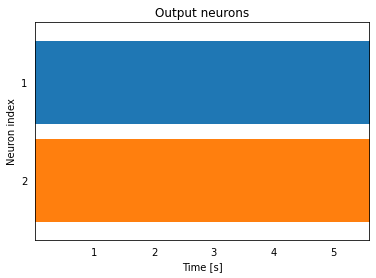

In [16]:
plt.title('Output neurons')
rasterplot(sim.trange(), sim.data[p_layer_1])
plt.xlabel("Time [s]")
plt.ylabel("Neuron index")

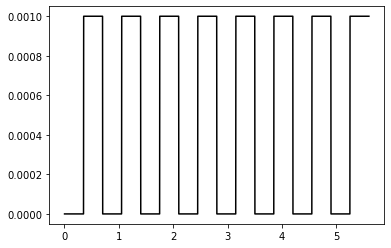

In [17]:
plt.plot(sim.trange(), sim.data[p_true_label]/1000, c='k', label='spikes')

In [3]:
def fun(X,
       a1=0,a2=1,a3=0,
       b1=1,b2=1,b3=1,b4=1,b5=1,b6=1,b7=1,
       c1=0,c2=1,c3=0,
       d1=1,d2=1,d3=1,d4=1,d5=1,d6=1,d7=1,
       e1=0, e2=0, e3=0, e4=0,e5=0,e6=0,
       alpha1=1,alpha2=0    
       ): 
            w, vmem = X
            w=np.array(w)
            vmem=np.array(vmem)
            vthp=0.25
            vthn=0.25
            vprog=1
            w_pos = e1*w + e3
            w_neg = e2*(1-w) + e4
            v_ov_p =  vmem - (vprog+vthp) + e5
            v_ov_n = (vprog-vthn) - vmem  + e6
            cond_1 = vmem<(vprog-vthn)
            cond_2 = vmem>(vprog+vthp)
            f1 = a1 + a2*(w_pos**1) + a3*(w_pos**2)
            g1 = b1 + b2*np.sin(b3*v_ov_n + b4) + b5*np.cos(b6*v_ov_n + b7)
            f2 = c1 + c2*(w_neg**1) + c3*(w_neg**2)
            g2 = d1 + d2*np.sin(d3*v_ov_p + d4) + d5*np.cos(d6*v_ov_p + d7)
            dW = (-1*cond_1*(alpha1*f1*g1))  + (cond_2*(alpha2*cond_2*f2*g2))    
            return dW
        
popt = np.array((-0.63268079,  1.92345965,  0.47470475,  0.08882345,  2.65286122,
       -3.50470788, -1.04094917,  2.46161541,  3.63797126, -0.54362876,
       -0.71246513,  3.70078799,  0.13785252, -2.05963654,  3.14470144,
        0.66939748,  0.37730831,  1.06771835,  1.13675002,  1.12284471,
        1.76493531,  3.54101003,  0.21334419,  0.16327218,  1.17173351,
       -0.3972994 , -1.62356781,  3.47649959))

class CustomRule(nengo.Process):
   
    def __init__(self, vthp=0.25, vthn=0.25, vprog=1,winit_min=0, winit_max=1):
       
        self.vthp = vthp
        self.vthn = vthn
        self.vprog = vprog  
        self.signal = None
        self.history = []
        self.update_history = []
        
        self.vmem_prev = 0
        
        self.winit_min = winit_min
        self.winit_max = winit_max
        
        super().__init__()
        
    def make_step(self, shape_in, shape_out, dt, rng, state=None):  
       
        self.w = np.random.uniform(self.winit_min, self.winit_max, (shape_out[0], shape_in[0]))
        
        def step(t, x):
            assert self.signal is not None
            
            vmem = self.signal[0]
                        
            # fill in the adjustment to the weight here
            # x is the spiking output of the pre-synaptic neurons so you can determine which neuron spiked
            dw = x*dt*fun((self.w,vmem*2),*popt)
#             dw = x*dt*fun((self.w,self.vmem_prev*2),*popt)
            
            self.w += dw
            self.update_history.append(dw.copy())
            self.vmem_prev = vmem.copy()
            return np.dot(self.w, x)
        
        return step   
    
    def set_signal(self, signal):
        self.signal = signal